In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error

In [2]:
data=pd.read_excel("jharkhand.xlsx")

In [56]:
data['Timestamp']=pd.to_datetime(data.Timestamp)

In [57]:
df=data.iloc[:]

In [58]:
lis = df['demand'].tolist()

In [59]:
creating_new=[]
for i in range(43968):
    if(i<96):
        creating_new.append(lis[i])
    else:
        creating_new.append(lis[i-96])

In [60]:
df['demand_prev']=creating_new

In [61]:
cols=list(df)[1:3]

In [24]:
df1= df.iloc[:38400]
df2=df.iloc[38400:]

In [64]:
dataset=df[cols].astype(float)
train_1 = df1[cols].astype(float)
test_1 = df2[cols].astype(float)

In [65]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(train_1)
train = scaler.transform(train_1)
test = scaler.transform(test_1)

In [66]:
# Using 400 days as train and 58 days for testing

In [67]:
n_future=1
n_past=96

In [68]:
def splitter(dataset, n_past,n_future):
    X=[]
    Y=[]
    for i in range(n_past,len(dataset) - n_future+1):
        X.append(dataset[i-n_past:i,0:dataset.shape[1]])
        Y.append(dataset[i+n_future-1:i+n_future,0])
    return np.array(X),np.array(Y)


In [69]:
trainX,trainY=splitter(train,n_past,n_future)
testX,testY=splitter(test,n_past,n_future)

In [73]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 96, 64)            17152     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [74]:
history = model.fit(trainX, trainY, epochs=2, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/2
2155/2155 [==============================] - 179s 81ms/step - loss: 0.0059 - val_loss: 0.0064
Epoch 2/2
2155/2155 [==============================] - 176s 82ms/step - loss: 0.0037 - val_loss: 0.0087


In [75]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

171/171 [==============================] - 5s 29ms/step


In [76]:
prediction_copies = np.repeat(trainPredict, train.shape[1], axis=-1)
trainPredict = scaler.inverse_transform(prediction_copies)[:,0]

In [77]:
testX.shape

(5472, 96, 2)

In [78]:
prediction_copies = np.repeat(testPredict, train.shape[1], axis=-1)
testPredict = scaler.inverse_transform(prediction_copies)[:,0]

In [79]:
testPredict.shape

(5472,)

In [80]:
trainPredict

array([ 67.91742 ,  68.65208 ,  69.52577 , ..., 100.93996 , 101.13633 ,
       105.016914], dtype=float32)

In [81]:
dfnew=df.iloc[38400+96:]
dfnew['predict'] = testPredict

C:\Users\91939\AppData\Local\Temp\ipykernel_16944\2990976266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnew['predict'] = testPredict


In [82]:
dataset=data['demand'].astype(float)

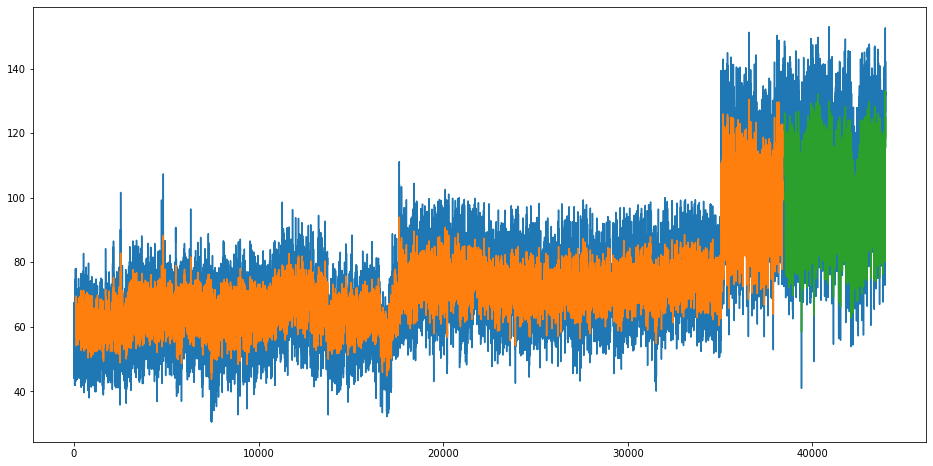

In [83]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[96:len(trainPredict)+96] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(96*2)-1:len(dataset)-1] = testPredict

# plot baseline and predictions
plt.figure(figsize=(16, 8))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [84]:
def mean_squared_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.square((y_true - y_pred) / y_true)) * 100

In [86]:
mspe = mean_squared_percentage_error(dfnew['demand'],testPredict[:])
print(f'Mean Squared Percentage Error: {mspe:.2f}%')

Mean Squared Percentage Error: 1.05%
